In [1]:
#from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,

    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "computer-modern-roman",
    
    "figure.dpi": 300,
    "savefig.dpi": 300,
})

import mplcursors

import h5py
import numpy as np
from numpy import array
import pandas as pd

h = 0.6774 # co-moving constant


In [2]:


dat = h5py.File('global_sample_data_snapshot_1200.hdf5')

# for x in dat.values():
#     try:
#         list(x)
#     except:
#         print(x)
#         raise
dat = pd.DataFrame((list(x) for x in dat.values() if x.shape != ()), index=(k for k in dat.keys() if dat[k].shape != ())).transpose()

In [3]:
dat['is_satellite'] = dat['groupID'] != -1

dat.loc[dat['is_satellite'] == False, 'plot_shape'] = 'o'
dat.loc[dat['is_satellite'], 'plot_shape'] = '^'

In [4]:
dat

,Mgas_ahf_cat,Mstar_ahf_cat,Mvir_ahf_cat,Redge,Redge_ahf,Rvir,Rvir_ahf,Rvir_ahf_cat,Xc_ahf_cat,Yc_ahf_cat,...,stellar_velocity_dispersion_los_z_within_r80,stellar_velocity_dispersion_los_z_within_r80_ahf,x_cm,x_cm_ahf,y_cm,y_cm_ahf,z_cm,z_cm_ahf,is_satellite,plot_shape
0,9.512860e+11,6.012280e+11,1.196040e+13,29.338589,29.338589,464.03,464.03,464.03,14711.058140,12986.948490,...,257.566324,257.566324,0.0,0.0,0.0,0.0,0.0,0.0,False,o
1,8.225730e+11,5.471810e+11,9.190950e+12,44.675458,44.675458,425.03,425.03,425.03,7908.847332,11816.418171,...,270.573159,270.573159,0.0,0.0,0.0,0.0,0.0,0.0,False,o
2,5.407820e+11,6.436700e+11,8.386820e+12,126.069141,126.069141,412.25,412.25,412.25,14807.960987,14623.553753,...,234.930793,234.930793,0.0,0.0,0.0,0.0,0.0,0.0,False,o
3,2.871070e+11,4.191250e+11,4.844970e+12,504.881648,504.881662,343.34,343.34,343.34,873.863697,14724.276066,...,285.986884,285.986827,0.0,0.0,0.0,0.0,0.0,0.0,False,o
4,2.366870e+11,2.783600e+11,4.160950e+12,43.142288,43.142288,326.36,326.36,326.36,10670.664310,14930.469990,...,251.522571,251.522571,0.0,0.0,0.0,0.0,0.0,0.0,False,o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,0.000000e+00,1.045510e+07,1.541840e+08,14.521914,14.521914,10.88,10.88,10.88,14459.381104,12862.701416,...,3.365012,3.283210,0.0,0.0,0.0,0.0,0.0,0.0,True,^
1716,0.000000e+00,6.139160e+06,1.737100e+08,8.795622,8.731912,6.77,6.77,6.77,14706.802368,13045.578003,...,195.162070,10.638386,0.0,0.0,0.0,0.0,0.0,0.0,True,^
1717,0.000000e+00,5.170780e+06,1.477650e+08,16.317195,16.289510,11.32,11.32,11.32,14655.075073,14626.235962,...,84.987186,8.732256,0.0,0.0,0.0,0.0,0.0,0.0,True,^
1718,0.000000e+00,4.018140e+06,1.093740e+08,13.768929,13.533950,9.70,9.70,9.70,14755.439758,14735.984802,...,39.167816,11.727622,0.0,0.0,0.0,0.0,0.0,0.0,True,^


In [5]:
list(dat.columns)

['Mgas_ahf_cat',
 'Mstar_ahf_cat',
 'Mvir_ahf_cat',
 'Redge',
 'Redge_ahf',
 'Rvir',
 'Rvir_ahf',
 'Rvir_ahf_cat',
 'Xc_ahf_cat',
 'Yc_ahf_cat',
 'Zc_ahf_cat',
 'dm_mass_within_r30_dm',
 'dm_mass_within_r30_dm_ahf',
 'dm_mass_within_r30_gas',
 'dm_mass_within_r30_gas_ahf',
 'dm_mass_within_r30_stars',
 'dm_mass_within_r30_stars_ahf',
 'dm_mass_within_r50_dm',
 'dm_mass_within_r50_dm_ahf',
 'dm_mass_within_r50_gas',
 'dm_mass_within_r50_gas_ahf',
 'dm_mass_within_r50_stars',
 'dm_mass_within_r50_stars_ahf',
 'dm_mass_within_r80_dm',
 'dm_mass_within_r80_dm_ahf',
 'dm_mass_within_r80_gas',
 'dm_mass_within_r80_gas_ahf',
 'dm_mass_within_r80_stars',
 'dm_mass_within_r80_stars_ahf',
 'galaxyID',
 'gas_mass_within_r30_dm',
 'gas_mass_within_r30_dm_ahf',
 'gas_mass_within_r30_gas',
 'gas_mass_within_r30_gas_ahf',
 'gas_mass_within_r30_stars',
 'gas_mass_within_r30_stars_ahf',
 'gas_mass_within_r50_dm',
 'gas_mass_within_r50_dm_ahf',
 'gas_mass_within_r50_gas',
 'gas_mass_within_r50_gas_ahf',

In [6]:
def sates(arr):
    return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] != -1), dtype=float)

def hosts(arr):
    return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] == -1), dtype=float)


m = {
    'Hosts': (dat[dat['is_satellite'] == False]),
    'Satellites': (dat[dat['is_satellite'] == True])
}

In [8]:
lin_fit_M_R50 = np.polynomial.Polynomial.fit(
    dat['stars_mass_within_r50_stars_ahf'],
    dat['r50_stars_ahf'],
    deg=1

lin_fit_M_R50

array([3.99359991e+00, 7.83554784e-12])

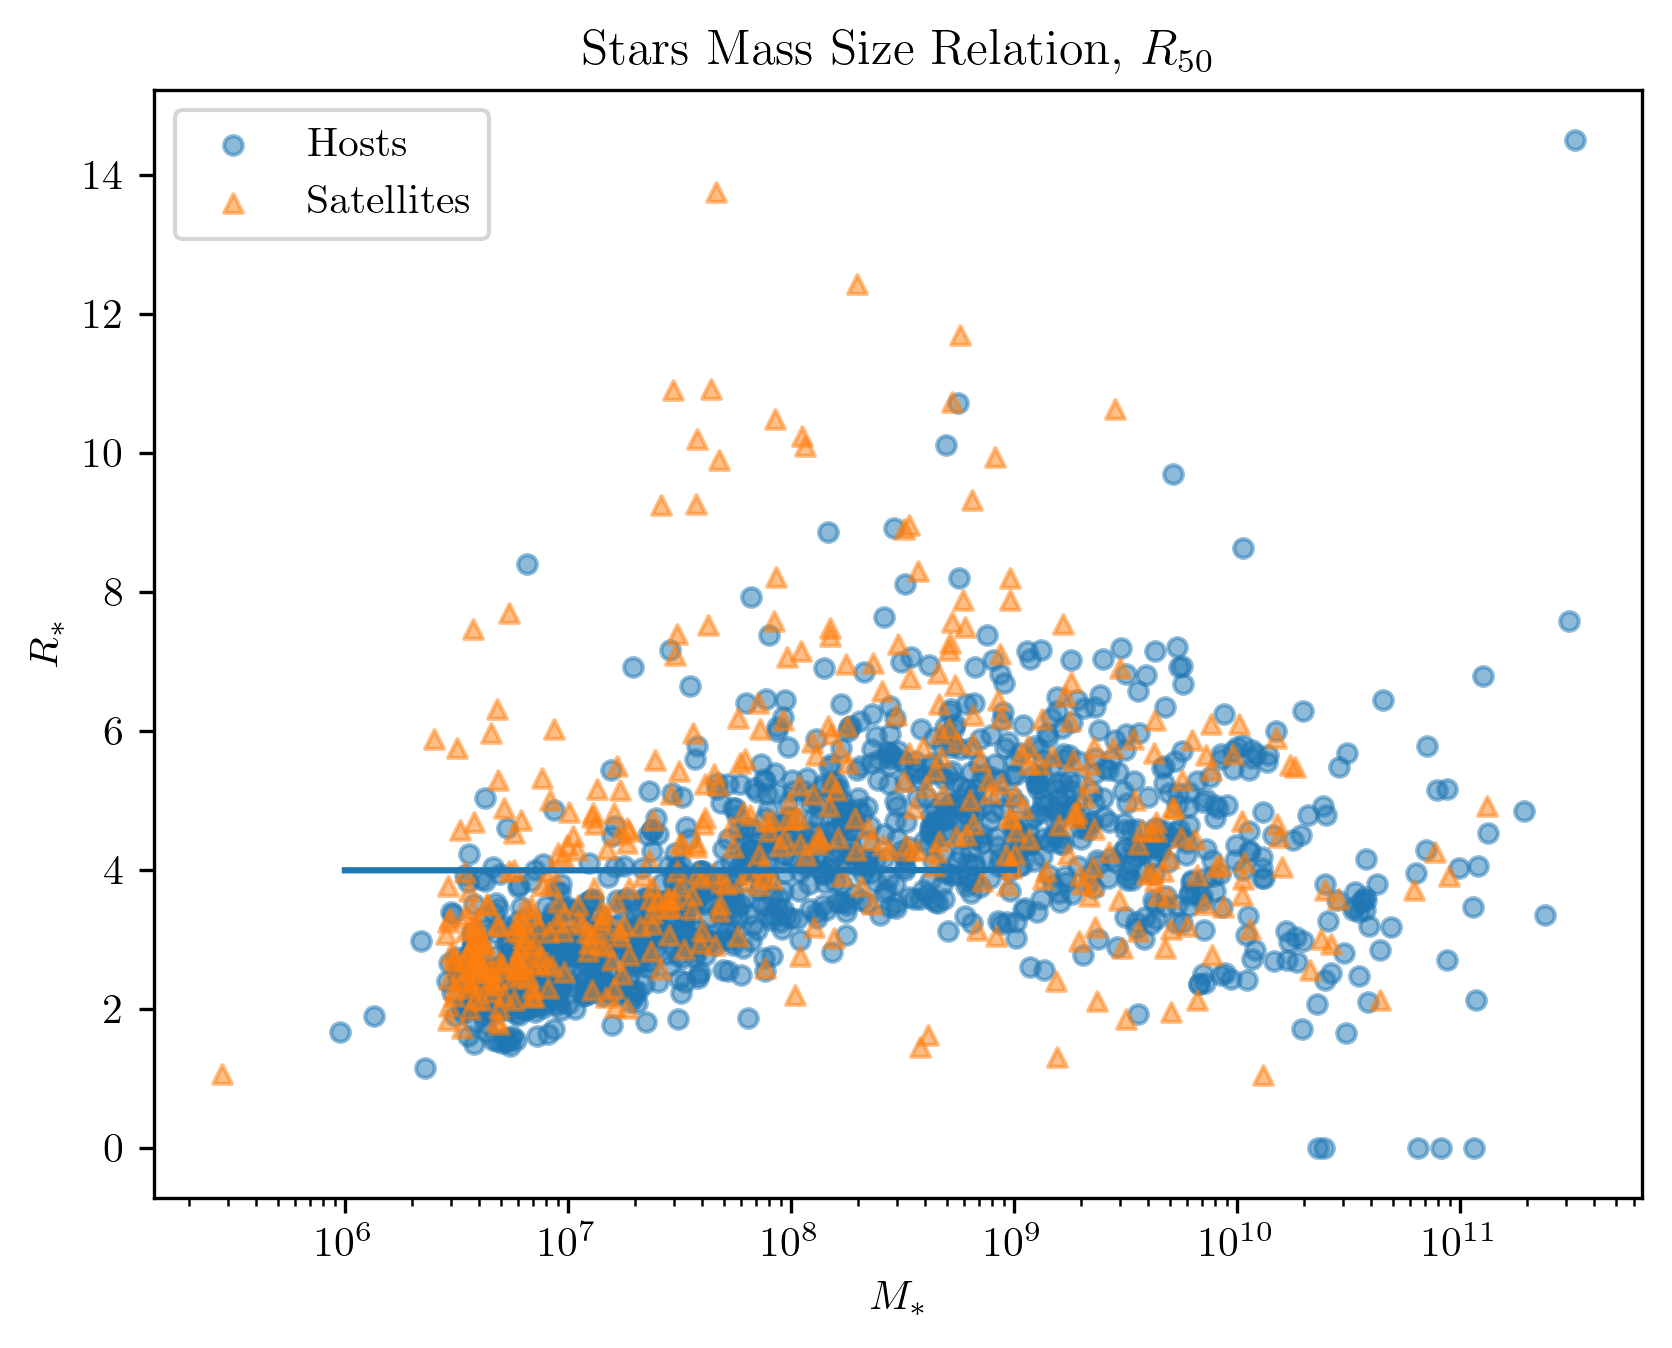

In [12]:

fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
#ax.set_yscale('log')
for mark, d in zip(('o', '^'), m.values()):
    x, y = d['stars_mass_within_r50_stars_ahf'], d['r50_stars_ahf']
    ax.scatter(x, y, alpha=0.5, s=20, marker=mark)


# polynomial
x = np.linspace(1e6, 1e9, 100)
y = lin_fit_M_R50(x)

ax.plot(x, y)

#ax.scatter(sates(x), sates(y), alpha=0.5, s=5)
# ax.set_xlim(3e6, 6e8)
#ax.set_ylim(1e6, 6e9)
ax.legend(tuple(m))
ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*}$')
ax.set_ylabel(r'$R_{*}$')
fig.savefig('out.pgf')



In [ ]:
list(x for x in dat.keys() if x.startswith('R'))

['Redge', 'Redge_ahf', 'Rvir', 'Rvir_ahf', 'Rvir_ahf_cat']

In [ ]:
prox = dat[:]

In [ ]:
# fig, ax = plt.subplots()

# #ax.set_xscale('log')
# #ax.set_yscale('log')
# dat['R']
# x, y, z = dat['Xc_ahf_cat'], dat['Yc_ahf_cat'], dat['Zc_ahf_cat']

# ax.scatter(hosts(y), hosts(z),  alpha=0.5, s=5)
# ax.scatter(sates(y), sates(z),  alpha=0.5, s=5)
# #ax.set_xlim(3e6, 6e8)
# #ax.set_ylim(1e6, 6e9)
# ax.legend(('Centrals', 'Satellites'))
# ax.set_xlabel('X (comoving)')
# ax.set_ylabel('Y (comoving)')
# fig.savefig('out.png')

# Proximity to host galaxy


In [17]:

dat['prox_to_host'] = np.nan

prox_to_host = np.zeros(dat.shape[0])

for i in range(len(prox_to_host)):
    host_info = dat[dat['groupID'][i] == dat['galaxyID']]
    host_i = host_info.first_valid_index()
    self_info = dat.iloc[i]

    if self_info.empty or host_info.empty:
        prox_to_host[i] = np.nan
        continue

    for j in ('Xc_ahf_cat', 'Yc_ahf_cat', 'Zc_ahf_cat'):
        diff = abs(host_info[j][host_i] - dat[j][i]) # coordinate delta
        diff = diff if diff < 7500 else 15000 - diff # to account for the coordinate wrap-around (the universe repeats!)
        prox_to_host[i] += (diff)**2

    prox_to_host[i] = np.sqrt(prox_to_host[i])
                
     
dat['prox_to_host'] = prox_to_host

In [18]:
prox_to_host

len(sates(dat['prox_to_host'])) - len(sates(dat['Xc_ahf_cat']))


0

<function __main__.<lambda>(sel)>

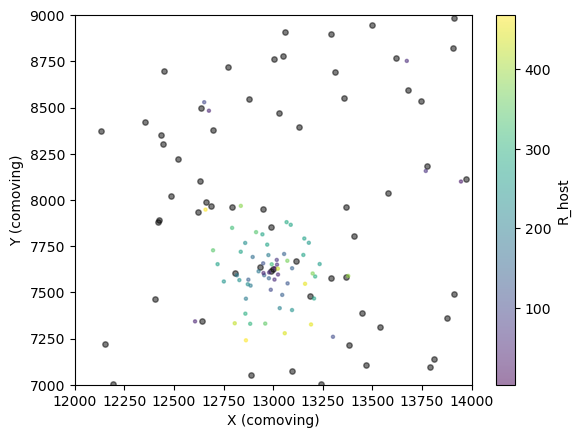

In [31]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = dat['Xc_ahf_cat'], dat['Yc_ahf_cat'], dat['Zc_ahf_cat']

ax.scatter(hosts(y), hosts(z),  alpha=0.5, s=15, color='black')

colors = sates((dat['prox_to_host']))
_mappable = ax.scatter(sates(y), sates(z),  alpha=0.5, s=5, c=colors)
fig.colorbar(_mappable, label='R_{host}')
ax.set_xlim((12000, 14000))
ax.set_ylim((7000, 9000))
ax.set_xlabel('X (comoving)')
ax.set_ylabel('Y (comoving)')
fig.savefig('out.png')

crs = mplcursors.cursor(ax)

crs.connect("add", lambda sel: sel.annotation.set_text(
    'Point {},{}'.format(sel.target[0], sel.target[1])))

In [ ]:
np.max(sates((prox_to_host)))

467.60530389753967

In [ ]:
max(dat['Xc_ahf_cat'])

14998.68392944

In [ ]:
# plt.switch_backend('QtAgg')

# fig = plt.figure()
# ax = mplot3d.axes3d.Axes3D(fig)

# z = np.linspace(0, 1, 100)
# y = np.sin(z)
# x = np.cos(z)

# ax.scatter3D(x, y, z)
# fig.show()


In [23]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
#ax.set_yscale('log')

x, y = dat['stars_mass_within_r50_stars_ahf'], dat['r50_stars_ahf']

#ax.scatter(hosts(x), hosts(y), alpha=0.5, s=10, marker='o', color='black')

colors = sates((dat['prox_to_host']))
_mappable = ax.scatter(sates(x), sates(y), alpha=0.5, s=20, marker='^', c=colors)
cbar = fig.colorbar(_mappable, label='R_host')
ax.set_xlim(3e6, 6e8)
#ax.set_ylim(1e6, 6e9)

#ax.legend(( 'Hosts', 'Satellites'))
ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*}$')
ax.set_ylabel(r'$R_{*}$')
fig.savefig('out.png')